## Notebook for understanding the change in Accuracy using Bayes

In [26]:
data = {
    "false_approve_rate": {
        "old": {
            "k": 11,
            "n": 254
        },
        "new": {
            "k": 0,
            "n": 47
        }
    },
    "false_rejection_rate": {
        "old": {
            "k": 24,
            "n": 10856
        },
        "new": {
            "k": 1,
            "n": 1723
        }
    },
    "missed_fraud_rate": {
        "old": {
            "k": 11,
            "n": 255
        },
        "new": {
            "k": 0,
            "n": 46
        }
    }
}

In [123]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

def bayesian_update(metric_name:str, old_k, old_n, new_k, new_n, max_rate=0.1):
    # --- 1. Define Prior --
    # Your old QA data from the last 3 months
    old_k = old_k  
    old_n = old_n  
    old_non_k = old_n - old_k

    # We use an uninformative prior Beta(1,1) and update it with the historical data
    # to get a a prior for the new experiment.
    alpha_prior = 1+ old_k  
    beta_prior = 1 + old_non_k

    old_metric_rate = old_k / old_n if old_n > 0 else 0

    print(f"Old {metric_name} (historical): {old_metric_rate*100:.4f}%")
    print(f"Prior for new rate: Beta(alpha={alpha_prior}, beta={beta_prior})")

    # --- 2. Collect New Data ---
    new_k = new_k 
    new_n = new_n  
    new_non_k = new_n - new_k

    new_metric_rate = new_k / new_n if new_n > 0 else 0
    
    print(f"New {metric_name} (this week): {new_metric_rate*100:.4f}%")

    # --- 3. Compute Posterior for New Rate ---
    # The posterior is simply the prior updated with the new data
    alpha_posterior = alpha_prior + new_k
    beta_posterior = beta_prior + new_non_k

    new_posterior_rate = alpha_posterior / (alpha_posterior + beta_posterior)
    
    delta = new_posterior_rate - old_metric_rate

    print(f"Posterior mean for new rate (this week): {new_posterior_rate*100:.4f}%")

    print(f"Posterior for new rate: Beta(alpha={alpha_posterior}, beta={beta_posterior})")

    print(f"\nResults for {metric_name}:")
    print(f'Change from old: {old_metric_rate*100:.4f}% to new: {new_posterior_rate*100:.4f}%')
    print(f"Delta: ({delta * 100:.2f}%)")

    # --- 4. Analyze and Visualize the Results ---
    # Generate distributions for plotting
    x = np.linspace(0, max_rate, 1000) # Range of possible metric from 0% to max_rate%
    # The historical rate's distribution is a Beta with alpha_prior and beta_prior
    old_rate_dist = beta.pdf(x, alpha_prior, beta_prior)
    # The new rate's distribution is the posterior
    new_rate_dist = beta.pdf(x, alpha_posterior, beta_posterior)

    # --- 5. Calculate Probability of an Improvement ---
    # The question is: What is the probability that the new rate is *lower* than the old rate?
    # We can estimate this by sampling from the two posterior distributions.
    num_samples = 100000
    old_samples = beta.rvs(alpha_prior, beta_prior, size=num_samples)
    new_samples = beta.rvs(alpha_posterior, beta_posterior, size=num_samples)

    # Probability that the new rate is less than the old rate
    prob_new_is_better = np.mean(new_samples < old_samples)

    print(f"Probability that the new {metric_name} is lower than the old one: {prob_new_is_better:.2%}")

    delta_samples = old_samples - new_samples

    # Calculate the probability that the improvement (delta) was between 0.3% and 0.5%
    # (i.e., between 0.003 and 0.005)
    prob_delta_range = np.mean((delta_samples >= abs(delta*0.5)) & (delta_samples <= abs(delta*1.5)))

    print(f"The probability of the improvement being between {delta*0.5*100:.2f}% and {delta*1.5*100:.2f}% is: {prob_delta_range:.2%}")

    # Plot the distributions
    plt.figure(figsize=(10, 6))
    plt.plot(x, old_rate_dist, label='Historical Rate (Prior)')
    plt.plot(x, new_rate_dist, label='New Rate (Posterior)')
    plt.axvline(x=old_k / old_n, color='gray', linestyle='--', label=f'Historical Rate Mean: {old_k / old_n:.4f}')
    plt.axvline(x=new_k / new_n, color='blue', linestyle='--', label=f'New Rate Mean: {new_k / new_n:.3f}')
    plt.axvline(x=new_posterior_rate, color='green', linestyle='--', label=f'New Posterior Rate Mean: {new_posterior_rate:.4f}')
    plt.title(f'Comparison of {metric_name} Distributions')
    plt.xlabel(metric_name)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()

Old false_approve_rate (historical): 4.3307%
Prior for new rate: Beta(alpha=12, beta=244)
New false_approve_rate (this week): 0.0000%
Posterior mean for new rate (this week): 3.9604%
Posterior for new rate: Beta(alpha=12, beta=291)

Results for false_approve_rate:
Change from old: 4.3307% to new: 3.9604%
Delta: (-0.37%)
Probability that the new false_approve_rate is lower than the old one: 66.02%
The probability of the improvement being between -0.19% and -0.56% is: 8.70%


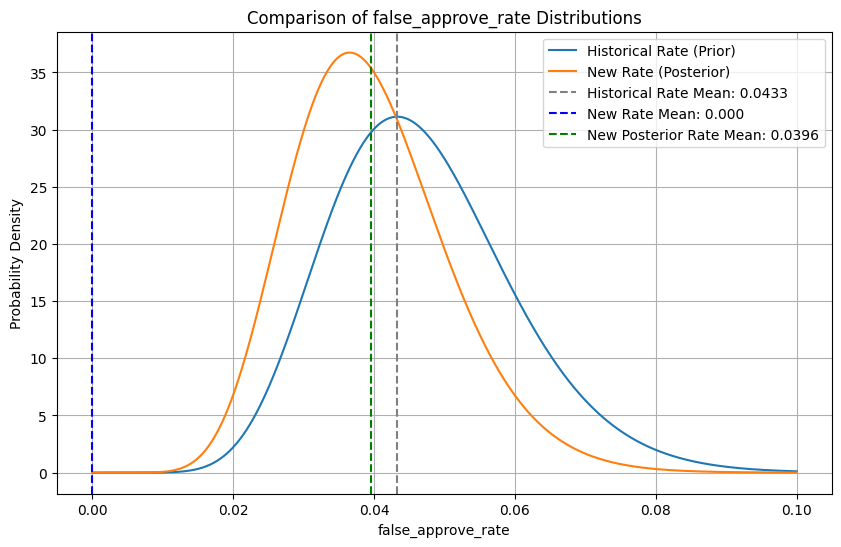

In [124]:
bayesian_update("false_approve_rate"
                , old_k = data['false_approve_rate']['old']['k']
                , old_n = data['false_approve_rate']['old']['n']
                , new_k = data['false_approve_rate']['new']['k']
                , new_n = data['false_approve_rate']['new']['n']
                , max_rate=0.1
                )

Old false_rejection_rate (historical): 0.2211%
Prior for new rate: Beta(alpha=25, beta=10833)
New false_rejection_rate (this week): 0.0580%
Posterior mean for new rate (this week): 0.2067%
Posterior for new rate: Beta(alpha=26, beta=12555)

Results for false_rejection_rate:
Change from old: 0.2211% to new: 0.2067%
Delta: (-0.01%)
Probability that the new false_rejection_rate is lower than the old one: 64.79%
The probability of the improvement being between -0.01% and -0.02% is: 9.39%


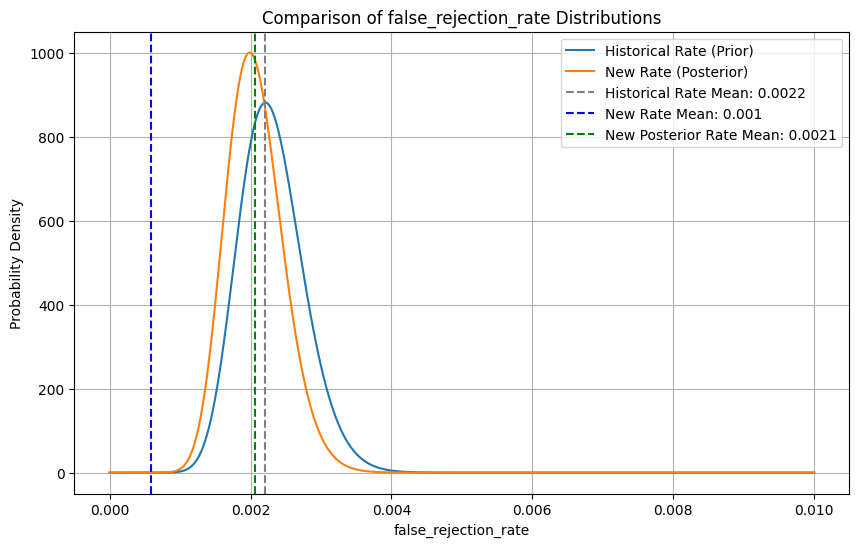

In [125]:
bayesian_update("false_rejection_rate"
                , old_k = data['false_rejection_rate']['old']['k']
                , old_n = data['false_rejection_rate']['old']['n']
                , new_k = data['false_rejection_rate']['new']['k']
                , new_n = data['false_rejection_rate']['new']['n']
                , max_rate=0.01
                )

Old missed_fraud_rate (historical): 4.3137%
Prior for new rate: Beta(alpha=12, beta=245)
New missed_fraud_rate (this week): 0.0000%
Posterior mean for new rate (this week): 3.9604%
Posterior for new rate: Beta(alpha=12, beta=291)

Results for missed_fraud_rate:
Change from old: 4.3137% to new: 3.9604%
Delta: (-0.35%)
Probability that the new missed_fraud_rate is lower than the old one: 66.11%
The probability of the improvement being between -0.18% and -0.53% is: 8.30%


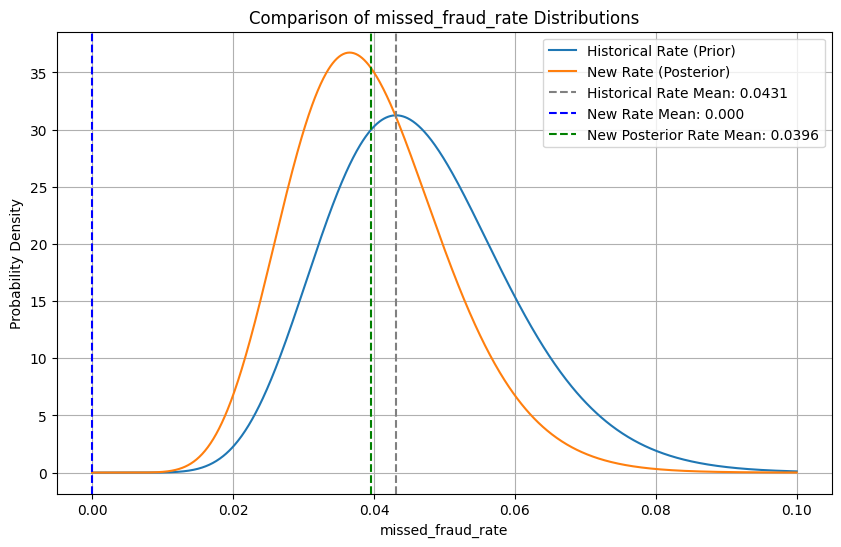

In [126]:
bayesian_update("missed_fraud_rate"
                , old_k = data['missed_fraud_rate']['old']['k']
                , old_n = data['missed_fraud_rate']['old']['n']
                , new_k = data['missed_fraud_rate']['new']['k']
                , new_n = data['missed_fraud_rate']['new']['n']
                , max_rate=0.1
                )